In [1]:
%matplotlib inline

import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pdal
from sklearn.neighbors.kde import KernelDensity
from six.moves.urllib.request import urlretrieve

In [2]:
url = 'https://github.com/PDAL/data/raw/master/isprs/'
last_percent_reported = None
data_root = '.' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

pc_filename = maybe_download('samp11-utm.laz', 99563)

('Found and verified', './samp11-utm.laz')


In [3]:
json = u'''
{
  "pipeline":[
    "%s",
    {
      "type":"filters.eigenvalues"
    },
    {
      "type":"filters.lof"
    },
    {
      "type":"filters.normal"
    },
    {
      "type":"filters.radialdensity"
    }
  ]
}''' % pc_filename

In [4]:
def dim_kde(arr, lb, ub):
    xp = np.linspace(lb, ub, 500)[:, np.newaxis]
    kde = KernelDensity(kernel='epanechnikov', bandwidth=0.25).fit(arr[:, np.newaxis])
    log_pdf = kde.score_samples(xp)
    plt.plot(xp, np.exp(log_pdf))

In [5]:
def dim_kde_full(arr, n=500, bw=0.25, k='epanechnikov'):
    xp = np.linspace(arr.min(), arr.max(), n)[:, np.newaxis]
    kde = KernelDensity(kernel=k, bandwidth=bw).fit(arr[:, np.newaxis])
    log_pdf = kde.score_samples(xp)
    plt.plot(xp, np.exp(log_pdf))

In [6]:
def dim_kde_mad(arr):
    m1, m2 = mad(arr)
    lb = m1 - 2*m2
    ub = m1 + 2*m2
    xp = np.linspace(lb, ub, 500)[:, np.newaxis]
    kde = KernelDensity(kernel='epanechnikov', bandwidth=0.25).fit(arr[:, np.newaxis])
    log_pdf = kde.score_samples(xp)
    plt.plot(xp, np.exp(log_pdf))

In [7]:
def dim_kde_std(arr):
    m1, m2 = arr.mean(), arr.std()
    lb = m1 - 2*m2
    ub = m1 + 2*m2
    xp = np.linspace(lb, ub, 500)[:, np.newaxis]
    kde = KernelDensity(kernel='epanechnikov', bandwidth=0.25).fit(arr[:, np.newaxis])
    log_pdf = kde.score_samples(xp)
    plt.plot(xp, np.exp(log_pdf))

In [8]:
def dim_kde_twoper(arr):
    lb = np.percentile(arr,2)
    ub = np.percentile(arr,98)
    xp = np.linspace(lb, ub, 500)[:, np.newaxis]
    kde = KernelDensity(kernel='epanechnikov', bandwidth=0.25).fit(arr[:, np.newaxis])
    log_pdf = kde.score_samples(xp)
    plt.plot(xp, np.exp(log_pdf))

In [9]:
def mad(arr):
    arr = np.ma.array(arr).compressed()
    med = np.median(arr)
    return med, np.median(np.abs(arr-med))

In [10]:
p = pdal.Pipeline(json)
p.validate()
count = p.execute()
data = p.arrays[0]

In [11]:
data.dtype.names

(u'X',
 u'Y',
 u'Z',
 u'Intensity',
 u'ReturnNumber',
 u'NumberOfReturns',
 u'ScanDirectionFlag',
 u'EdgeOfFlightLine',
 u'Classification',
 u'ScanAngleRank',
 u'UserData',
 u'PointSourceId',
 u'Eigenvalue0',
 u'Eigenvalue1',
 u'Eigenvalue2',
 u'KDistance',
 u'LocalReachabilityDistance',
 u'LocalOutlierFactor',
 u'NormalX',
 u'NormalY',
 u'NormalZ',
 u'Curvature',
 u'RadialDensity')

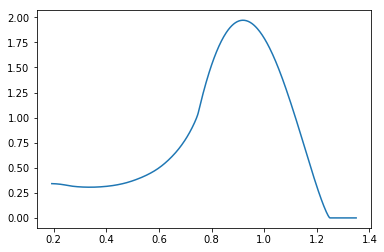

In [12]:
dim_kde_std(np.abs(data['NormalZ']))

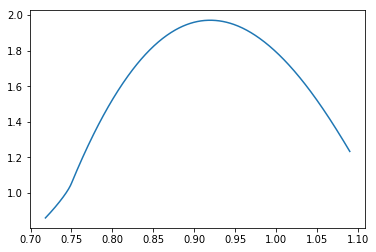

In [13]:
dim_kde_mad(np.abs(data['NormalZ']))

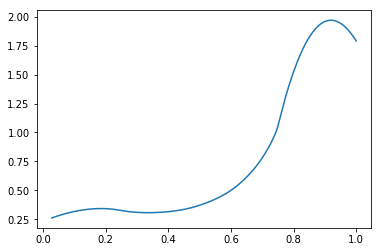

In [14]:
dim_kde_twoper(np.abs(data['NormalZ']))

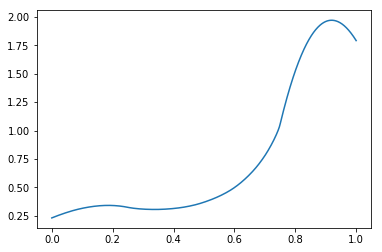

In [15]:
dim_kde_full(np.abs(data['NormalZ']), n=1000)